In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, sigmoid

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Loading the data

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# EDA 

### looking for missing values

In [8]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### Checking percentage of survivors

([<matplotlib.patches.Wedge at 0x7fad292c25d0>,
 [Text(-0.3925749350994583, 1.0275626113924428, 'Passed'),
  Text(0.3925750313068116, -1.0275625746369201, 'Survived')],
 [Text(-0.21413178278152267, 0.5604886971231505, '62%'),
  Text(0.21413183525826085, -0.5604886770746836, '38%')])

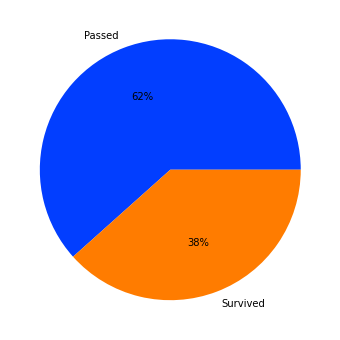

In [10]:
sv = train_data['Survived'].value_counts().to_frame()

plt.figure(figsize = (10, 6))
palette_color = sns.color_palette('bright')
plt.pie(sv["Survived"], labels=["Passed", "Survived"], colors=palette_color, autopct='%.0f%%')

### Inspect features

#### Pclass

Inspect the influence of Class on the probability of survival

In [11]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [12]:
survived_1st = len(train_data.loc[(train_data["Pclass"] == 1) & (train_data["Survived"] == 1)])
all_1st = len(train_data[train_data["Pclass"] == 1])
survived_1st_rate = (survived_1st / all_1st) * 100
print(f"percentage of survived people among 1st class passengers {survived_1st_rate:0.2f} %")

percentage of survived people among 1st class passengers 62.96 %


In [13]:
survived_2nd = len(train_data.loc[(train_data["Pclass"] == 2) & (train_data["Survived"] == 1)])
all_2nd = len(train_data[train_data["Pclass"] == 2])
survived_2nd_rate = (survived_2nd / all_2nd) * 100
print(f"percentage of survived people among 2nd class passengers {survived_2nd_rate:0.2f} %")

percentage of survived people among 2nd class passengers 47.28 %


In [14]:
survived_3rd = len(train_data.loc[(train_data["Pclass"] == 3) & (train_data["Survived"] == 1)])
all_3rd = len(train_data[train_data["Pclass"] == 3])
survived_3rd_rate = (survived_3rd / all_3rd) * 100
print(f"percentage of survived people among 3rd class passengers {survived_3rd_rate:0.2f} %")

percentage of survived people among 3rd class passengers 24.24 %


<AxesSubplot:xlabel='Pclass', ylabel='count'>

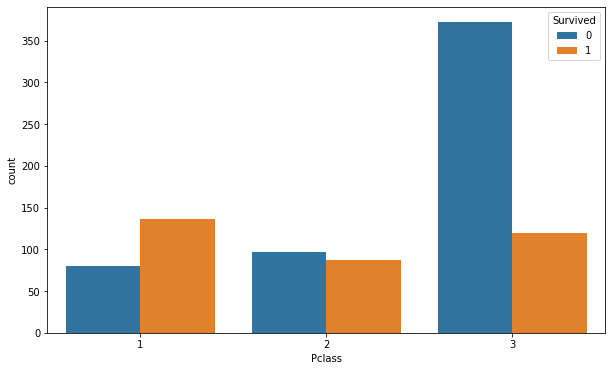

In [15]:
plt.figure(figsize = (10, 6))
sns.countplot(data = train_data, x = "Pclass", hue = "Survived")

#### Name

We extract title from passengers names

In [16]:
train_data["Title"] = train_data.Name.str.extract("([\ba-zA-Z]+\.)", expand = False)
test_data["Title"] = test_data.Name.str.extract("([\ba-zA-Z]+\.)", expand = False)

In [17]:
train_data["Title"].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'Countess.', 'Jonkheer.'], dtype=object)

In [18]:
train_data["Title"].value_counts().to_frame()

,Title
Mr.,517
Miss.,182
Mrs.,125
Master.,40
Dr.,7
Rev.,6
Mlle.,2
Major.,2
Col.,2
Countess.,1


In [19]:
test_data["Title"].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Ms.', 'Col.', 'Rev.', 'Dr.',
       'Dona.'], dtype=object)

In [20]:
test_data["Title"].value_counts()

Mr.        240
Miss.       78
Mrs.        72
Master.     21
Col.         2
Rev.         2
Ms.          1
Dr.          1
Dona.        1
Name: Title, dtype: int64

#### Sex

We inspect the influence of this feature on survival

In [21]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [22]:
survived_men = sum(train_data.loc[train_data.Sex == 'male']["Survived"])
all_men = len(train_data.loc[train_data.Sex == 'male']["Survived"])
men_rate = survived_men / all_men
print(f"percentage of men who survived {(men_rate*100):0.2f} %")

percentage of men who survived 18.89 %


In [23]:
survived_women = sum(train_data.loc[train_data.Sex == 'female']["Survived"])
all_women = len(train_data.loc[train_data.Sex == 'female']["Survived"])
women_rate = survived_women / all_women
print(f"percentage of women who survived {(women_rate*100):0.2f} %")

percentage of women who survived 74.20 %


Text(0.5, 1.0, "Men's Survival Rate")

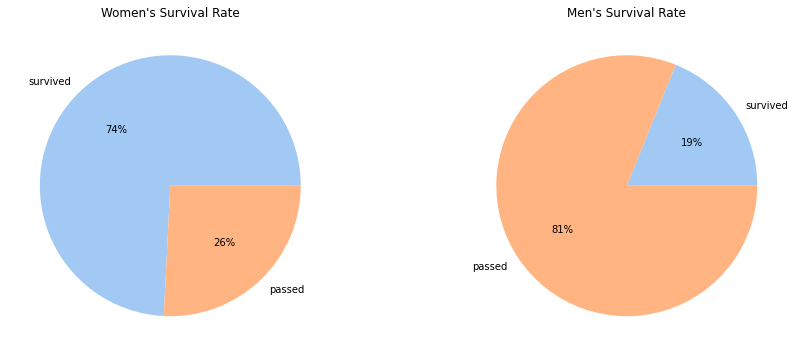

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
palette_color = sns.color_palette('pastel')
ax1.pie(x = [survived_women, (all_women - survived_women)], labels = ["survived", "passed"], colors = palette_color, autopct='%.0f%%')
ax2.pie(x = [survived_men, (all_men - survived_men)], labels = ["survived", "passed"], colors = palette_color, autopct='%.0f%%')
ax1.set_title("Women's Survival Rate")
ax2.set_title("Men's Survival Rate")

#### Age

We have lot of missing age values, we can try to fill this by getting approximations based on the titles extracted from names

In [25]:
train_data.groupby("Title")["Age"].median().to_frame()

,Age
Title,
Capt.,70.0
Col.,58.0
Countess.,33.0
Don.,40.0
Dr.,46.5
Jonkheer.,38.0
Lady.,48.0
Major.,48.5
Master.,3.5


In [26]:
test_data.groupby("Title")["Age"].median().to_frame()

,Age
Title,
Col.,50.0
Dona.,39.0
Dr.,53.0
Master.,7.0
Miss.,22.0
Mr.,28.5
Mrs.,36.5
Ms.,NaN
Rev.,35.5


In [27]:
age_dictionary = {
    'Mr.' : 30,
    'Mrs.' : 35,
    'Miss.' : 21,
    'Master.' : 3.5,
    'Don.' : 40,
    'Rev.' : 46.5,
    'Dr.' : 46.5,
    'Mme.' : 24,
    'Ms.' : 28,
    'Major.' : 48.5,
    'Lady.' : 48,
    'Sir.' : 49,
    'Mlle.' : 24,
    'Col.': 58,
    'Capt.' : 70,
    'Countess.' : 33,
    'Jonkheer.' : 38,
    'Dona.' :  39
}

In [28]:
for title in train_data["Title"].unique():
    
    train_data.loc[(train_data["Age"].isnull()) & (train_data["Title"] == title), "Age"] = age_dictionary[title]

In [29]:
len(train_data[train_data["Age"].isnull()])

0

In [30]:
for title in test_data["Title"].unique():
    
    test_data.loc[(test_data["Age"].isnull()) & (test_data["Title"] == title), "Age"] = age_dictionary[title]

In [31]:
len(test_data[test_data["Age"].isnull()])

0

<AxesSubplot:xlabel='Age', ylabel='Density'>

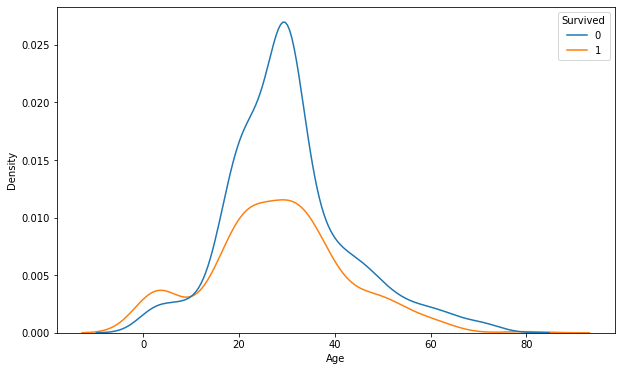

In [32]:
plt.figure(figsize = (10, 6))
sns.kdeplot(data=train_data, x="Age", hue="Survived")

#### SibSp and Parch

Siblings, Spouses, Parents and Children

In [33]:
train_data["SibSp"].value_counts().to_frame()

,SibSp
0,608
1,209
2,28
4,18
3,16
8,7
5,5


In [34]:
train_data["Parch"].value_counts().to_frame()

,Parch
0,678
1,118
2,80
5,5
3,5
4,4
6,1


Text(0.5, 1.0, 'Survival according to number of Parents/Children')

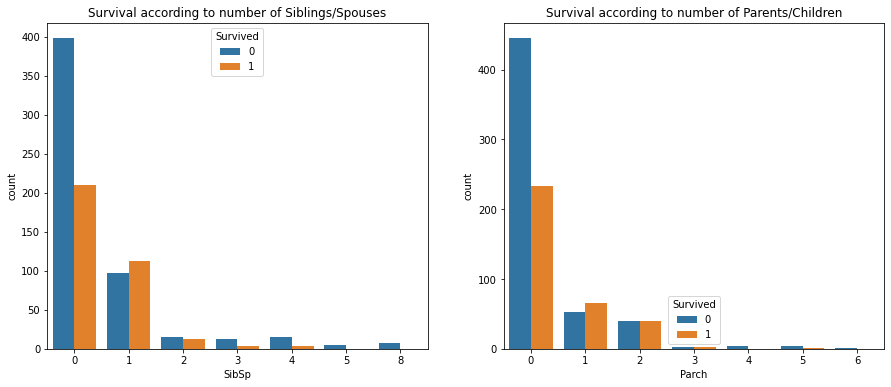

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
sns.countplot(data = train_data, x = "SibSp", hue = "Survived", ax=ax1)
ax1.set_title("Survival according to number of Siblings/Spouses")
sns.countplot(data = train_data, x = "Parch", hue = "Survived", ax=ax2)
ax2.set_title("Survival according to number of Parents/Children")

#### Embarked

Passengers embarked from Southampton, Cherbourg or Queenstown 

In [36]:
train_data["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [37]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [38]:
train_data.groupby("Embarked")["Survived"].sum()

Embarked
C     93
Q     30
S    217
Name: Survived, dtype: int64

Text(0.5, 1.0, 'Embarked from Southampton')

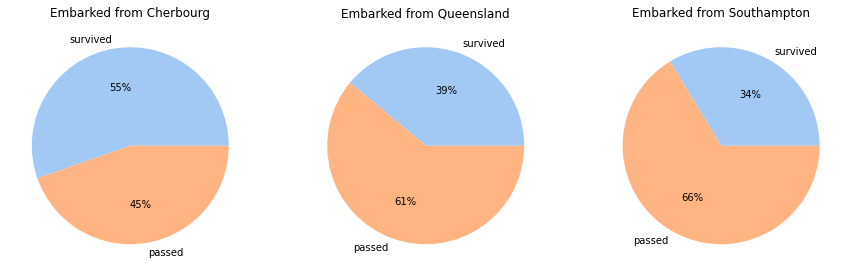

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
palette_color = sns.color_palette('pastel')
ax1.pie(x = [93, 75], labels = ["survived", "passed"], colors = palette_color, autopct='%.0f%%')
ax2.pie(x = [30, 47], labels = ["survived", "passed"], colors = palette_color, autopct='%.0f%%')
ax3.pie(x = [217, 427], labels = ["survived", "passed"], colors = palette_color, autopct='%.0f%%')
ax1.set_title("Embarked from Cherbourg")
ax2.set_title("Embarked from Queensland")
ax3.set_title("Embarked from Southampton")

In [40]:
train_data[train_data["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss.
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs.


In [41]:
train_data[train_data['Cabin'].str.match('B2\d')== True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss.
540,541,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.0,B22,S,Miss.
690,691,1,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0,B20,S,Mr.
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,B22,S,Capt.
781,782,1,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1,0,17474,57.0,B20,S,Mrs.
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs.


Two null Embarked values are probably "S" since passengers who have cabins with similar values have embarked from Southampton

In [42]:
train_data["Embarked"].fillna("S", inplace = True)

In [43]:
len(test_data[test_data["Age"].isnull()])

0

We also have one null "Fare" value we need to fill

In [44]:
test_data[test_data["Fare"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr.


In [45]:
test_data.groupby(["Pclass", "Embarked"])["Fare"].median().to_frame()

Fare
Pclass Embarked          
1      C         75.24585
       Q         90.00000
       S         51.67085
2      C         15.04580
       Q         11.52915
       S         21.00000
3      C          7.22920
       Q          7.75000
       S          8.05000

Since the person with the null Fare value is in 3rd class and has embarked from Southampton, The Fare value should be around 8.05

In [46]:
test_data.loc[test_data["Fare"].isnull(), "Fare"] = 8.05

In [47]:
len(test_data[test_data["Fare"].isnull()])

0

In [48]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [49]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  Title        418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


# Split The Data

In [50]:
X = train_data.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin", "Title"], axis=1 ) 
y = train_data["Survived"].to_frame()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_data.drop(["PassengerId", "Name", "Ticket", "Cabin", "Title"], axis=1)

In [51]:
X_train[['Sex', 'Embarked']] = X_train[['Sex', 'Embarked']].apply(LabelEncoder().fit_transform)
X_val[['Sex', 'Embarked']] = X_val[['Sex', 'Embarked']].apply(LabelEncoder().fit_transform)
X_test[['Sex', 'Embarked']] = X_test[['Sex', 'Embarked']].apply(LabelEncoder().fit_transform)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,1,45.5,0,0,28.5000,2
733,2,1,23.0,0,0,13.0000,2
382,3,1,32.0,0,0,7.9250,2
704,3,1,26.0,1,0,7.8542,2
813,3,0,6.0,4,2,31.2750,2


# Logistic Regression

In [52]:
params = { 'model__C' : np.arange(0.001, 0.1, 0.001) }

LR_pipeline = Pipeline([('Scaler', StandardScaler()),
                             ('model', LogisticRegression(random_state=42))])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
LR_GS = GridSearchCV(LR_pipeline, param_grid=params, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
LR_GS.fit(X_train, y_train.values.ravel())
LR_model = LR_GS.best_estimator_[1]
print(LR_GS.best_score_,
LR_GS.best_params_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
0.810371318822023 {'model__C': 0.013000000000000001}


In [53]:
scaler = StandardScaler().fit(X_val)
X_val = scaler.transform(X_val)
LR_predicts = LR_model.predict(X_val)
score = LR_model.score(X_val, y_val.values.ravel())
f1score = f1_score(LR_predicts, y_val.values.ravel())
print(f"score : {score}, f1_score : {f1score}")

score : 0.8100558659217877, f1_score : 0.746268656716418


# Random Forest Classifier

In [54]:
params = { 'model__max_depth' : np.arange(2, 10, 1),
         'model__n_estimators' : np.arange(60, 80, 1)
         }
RF_pipeline = Pipeline([('scaler' , StandardScaler()),
                            ('model' , RandomForestClassifier(random_state=42))])

RF_GS = GridSearchCV(RF_pipeline, param_grid=params, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
RF_GS.fit(X_train, y_train.values.ravel())
RF_model = RF_GS.best_estimator_[1]
print(RF_GS.best_score_, RF_GS.best_params_)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
0.8342460356544864 {'model__max_depth': 4, 'model__n_estimators': 73}


In [55]:
RF_predicts = RF_model.predict(X_val)
score = RF_model.score(X_val, y_val.values.ravel())
f1score = f1_score(RF_predicts, y_val.values.ravel())
print(f"score : {score}, f1_score : {f1score}")

score : 0.8044692737430168, f1_score : 0.7445255474452555


# XGBoost Classifier

In [56]:
params = { 'model__max_depth' : np.arange(2, 10, 1),
         'model__n_estimators' : np.arange(70, 75, 1)
         }
XG_pipeline = Pipeline([('scaler' , StandardScaler()),
                            ('model' , XGBClassifier(random_state=42))])

XG_GS = GridSearchCV(XG_pipeline, param_grid=params, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
XG_GS.fit(X_train, y_train.values.ravel())
XG_model = XG_GS.best_estimator_[1]
print(XG_GS.best_score_, XG_GS.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
0.8244459765586527 {'model__max_depth': 3, 'model__n_estimators': 71}


In [57]:
XG_predicts = XG_model.predict(X_val)
score = XG_model.score(X_val, y_val.values.ravel())
f1score = f1_score(XG_predicts, y_val.values.ravel())
print(f"score : {score}, f1_score : {f1score}")

score : 0.7877094972067039, f1_score : 0.7246376811594203


# Neural Network

In [58]:
X1_train = StandardScaler().fit(X_train).transform(X_train)

tf.random.set_seed(42) 
NN_model = Sequential(
    [               
        Dense(25, activation = 'relu'),
        Dense(10, activation = 'relu'),
        Dense(10, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
      
    ] 
)


NN_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

NN_model.fit(
    X1_train,y_train,
    epochs=70
)

2022-09-17 01:45:05.782838: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-17 01:45:05.921247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70
23/23 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.4705
Epoch 2/70
23/23 [==============================] - 0s 2ms/step - loss: 0.6500 - accuracy: 0.7514
Epoch 3/70
23/23 [==============================] - 0s 2ms/step - loss: 0.6124 - accuracy: 0.7851
Epoch 4/70
23/23 [==============================] - 0s 2ms/step - loss: 0.5610 - accuracy: 0.7935
Epoch 5/70
23/23 [==============================] - 0s 2ms/step - loss: 0.5061 - accuracy: 0.7949
Epoch 6/70
23/23 [==============================] - 0s 2ms/step - loss: 0.4691 - accuracy: 0.8020
Epoch 7/70
23/23 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.8062
Epoch 8/70
23/23 [==============================] - 0s 2ms/step - loss: 0.4442 - accuracy: 0.8062
Epoch 9/70
23/23 [==============================] - 0s 2ms/step - loss: 0.4386 - accuracy: 0.8076
Epoch 10/70
23/23 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.8104
Epoch 11/70
23/23 [

In [59]:
NN_predicts = NN_model.predict(X_val)

In [60]:
def b_convert(X):
    b_predicts = []
    for i in range(X.shape[0]):
        if X[i] < 0.5 :
            b_predicts.append(0)
        else :
            b_predicts.append(1)
    return b_predicts

b_predicts = b_convert(NN_predicts)
Accuracy_score = accuracy_score(b_predicts, y_val.values.ravel())
F1_score = f1_score(b_predicts, y_val.values.ravel())
print(f"Score {Accuracy_score}, F1_score {F1_score}")


Score 0.8268156424581006, F1_score 0.7669172932330828


**Comparing the models above the neural network has the best accuracy and f1 scores**

In [61]:
X_test = StandardScaler().fit(X_test).transform(X_test)
predicts = NN_model.predict(X_test)
b_predicts = b_convert(predicts)

In [62]:
submission = test_data['PassengerId'].to_frame()
submission['Survived'] = b_predicts
submission.to_csv(f"submission.csv", index=False)

In [63]:
submission.to_csv(f"submission.csv", index=False)

In [64]:
model_l = LogisticRegression()
model_l.fit(StandardScaler().fit(X_train).transform(X_train), y_train.values.ravel())
predicts = model_l.predict(StandardScaler().fit(X_val).transform(X_val))